In [77]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [78]:
data = pd.read_excel('Офіційний курс гривні щодо іноземних валют.xlsx')
data.head(10)

,Дата,Час,Код цифровий,Код літерний,Кількість одиниць,Назва валюти,"Офіційний курс гривні, грн"
0,01.01.2024,0.0,978,EUR,1,Євро,41.9960
1,02.01.2024,0.0,978,EUR,1,Євро,42.0059
2,03.01.2024,0.0,978,EUR,1,Євро,41.7209
3,04.01.2024,0.0,978,EUR,1,Євро,41.6073
4,05.01.2024,0.0,978,EUR,1,Євро,41.6665
5,06.01.2024,0.0,978,EUR,1,Євро,41.6665
6,07.01.2024,0.0,978,EUR,1,Євро,41.6665
7,08.01.2024,0.0,978,EUR,1,Євро,41.5730
8,09.01.2024,0.0,978,EUR,1,Євро,41.7973
9,10.01.2024,0.0,978,EUR,1,Євро,41.8185


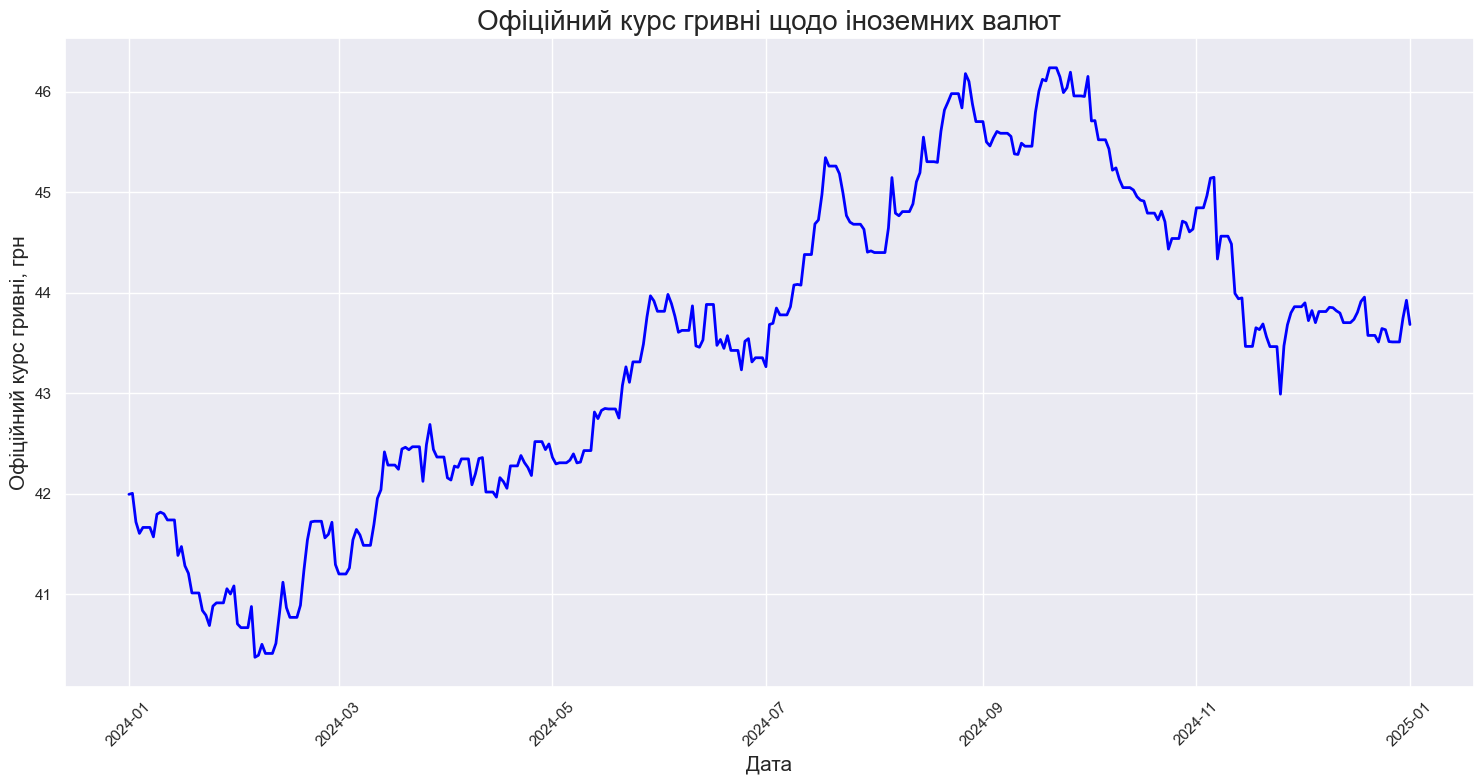

In [79]:
mask = pd.to_datetime(data['Дата'], format='%d.%m.%Y') >= pd.to_datetime('01.01.2024', format='%d.%m.%Y')
data_filtered = data[mask]
data_filtered = data_filtered.drop_duplicates(subset='Дата', keep='first')

date = data_filtered['Дата'].to_numpy()
value = data_filtered['Офіційний курс гривні, грн'].to_numpy()
date = pd.to_datetime(date, format='%d.%m.%Y')


plt.figure(figsize=(15, 8))
plt.plot(date, value, color='blue', linewidth=2)
plt.title('Офіційний курс гривні щодо іноземних валют', fontsize=20)
plt.xlabel('Дата', fontsize=15)
plt.ylabel('Офіційний курс гривні, грн', fontsize=15)
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


Тестування сезонного періоду: 5
Найкращі параметри для сезонності 5:
alpha=0.060000000000000005, beta=0.26, gamma=0.01
MSE: 0.175258
MAE: 0.327575

Тестування сезонного періоду: 7
Найкращі параметри для сезонності 7:
alpha=0.060000000000000005, beta=0.26, gamma=0.01
MSE: 0.165196
MAE: 0.315688

Тестування сезонного періоду: 10
Найкращі параметри для сезонності 10:
alpha=0.060000000000000005, beta=0.21000000000000002, gamma=0.41000000000000003
MSE: 0.158068
MAE: 0.298345

Тестування сезонного періоду: 12
Найкращі параметри для сезонності 12:
alpha=0.060000000000000005, beta=0.26, gamma=0.060000000000000005
MSE: 0.147687
MAE: 0.319675

Тестування сезонного періоду: 20
Найкращі параметри для сезонності 20:
alpha=0.060000000000000005, beta=0.21000000000000002, gamma=0.41000000000000003
MSE: 0.151261
MAE: 0.325231

Загальні найкращі параметри:
alpha=0.060000000000000005, beta=0.26, gamma=0.060000000000000005
Сезонний період: 12
Найкращий MSE: 0.147687
Найкращий MAE: 0.319675


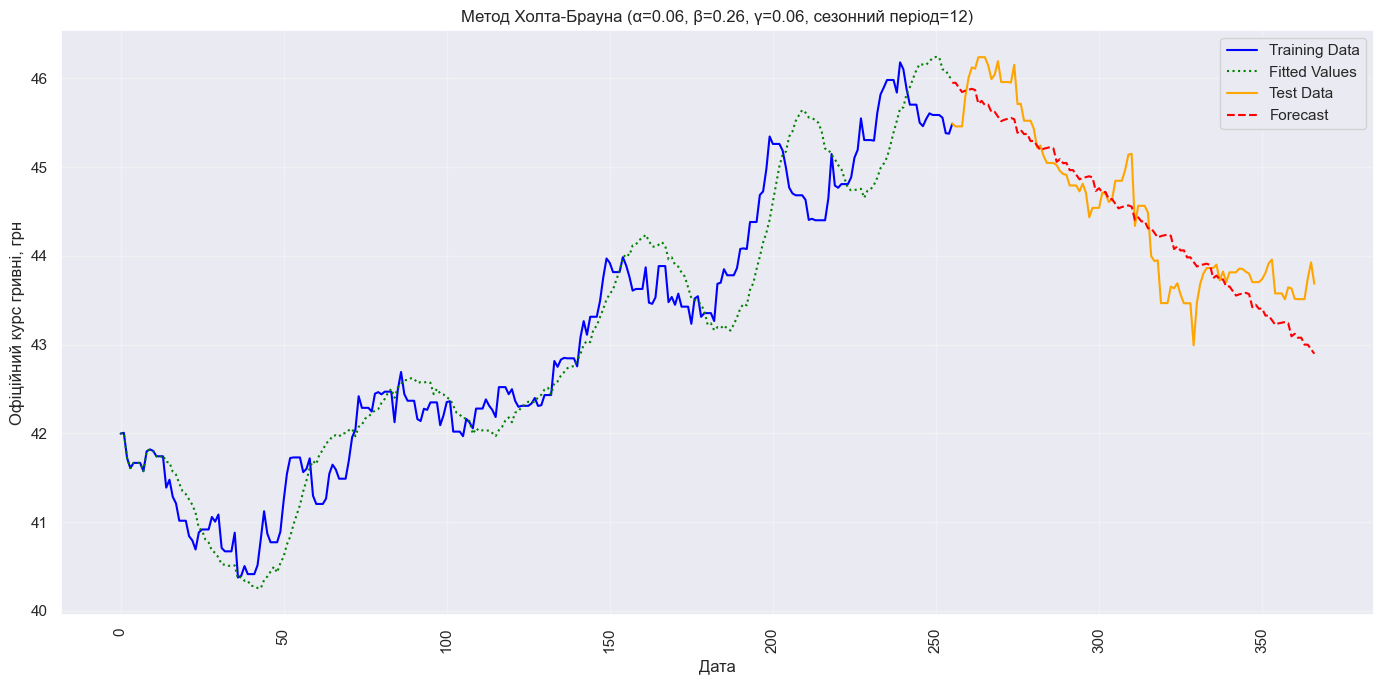


Метрики при тренуванні:
MSE: 0.186434
RMSE: 0.431780
MAE: 0.338611
MAPE: 0.778948

Метрики при прогнозуванні:
MSE: 0.147687
RMSE: 0.384300
MAE: 0.319675
MAPE: 0.719531


In [81]:
def holt_winters_forecast(data, alpha, beta, gamma, seasonal_periods, forecast_periods):
    n = len(data)
    level = np.zeros(n)
    trend = np.zeros(n)
    seasonal = np.zeros(n)

    level[0] = data[0]
    trend[0] = data[1] - data[0]

    season_averages = [np.mean(data[i::seasonal_periods]) for i in range(seasonal_periods)]
    global_average = np.mean(season_averages)
    initial_seasonal = [avg / global_average for avg in season_averages]

    for i in range(seasonal_periods):
        seasonal[i] = initial_seasonal[i % len(initial_seasonal)]

    for i in range(1, n):
        if i >= seasonal_periods:
            level[i] = alpha * (data[i] / seasonal[i - seasonal_periods]) + (1 - alpha) * (level[i - 1] + trend[i - 1])
            trend[i] = beta * (level[i] - level[i - 1]) + (1 - beta) * trend[i - 1]
            seasonal[i] = gamma * (data[i] / level[i]) + (1 - gamma) * seasonal[i - seasonal_periods]
        else:
            level[i] = alpha * data[i] + (1 - alpha) * (level[i - 1] + trend[i - 1])
            trend[i] = beta * (level[i] - level[i - 1]) + (1 - beta) * trend[i - 1]

    fitted_values = np.array([
        level[i] * seasonal[i] if i >= seasonal_periods else data[i]
        for i in range(n)
    ])

    forecast = np.zeros(n + forecast_periods)
    forecast[:n] = fitted_values

    for i in range(n, n + forecast_periods):
        season_idx = (i - seasonal_periods) % seasonal_periods
        forecast[i] = (level[-1] + trend[-1] * (i - n + 1)) * seasonal[season_idx]

    return forecast, fitted_values

def calculate_errors(actual, predicted):
    return {
        'MSE': np.mean((actual - predicted) ** 2),
        'RMSE': np.sqrt(np.mean((actual - predicted) ** 2)),
        'MAE': np.mean(np.abs(actual - predicted)),
        'MAPE': np.mean(np.abs((actual - predicted) / actual)) * 100
    }

def plot_forecast_with_fitted(train, test, fitted_values, forecast_values, title="Холт-Браун"):
    plt.figure(figsize=(14, 7))
    plt.plot(train.index, train['Офіційний курс гривні, грн'], label='Training Data', color='blue')
    plt.plot(train.index, fitted_values, label='Fitted Values', color='green', linestyle=':')
    plt.plot(test.index, test['Офіційний курс гривні, грн'], label='Test Data', color='orange')
    plt.plot(test.index, forecast_values[len(train):], label='Forecast', color='red', linestyle='--')
    plt.title(title)
    plt.xlabel('Дата')
    plt.ylabel('Офіційний курс гривні, грн')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

# Підготовка даних
train_len = int(len(data_filtered) * 0.7)
train = data_filtered.iloc[:train_len].copy()
test = data_filtered.iloc[train_len - 1:].copy()

train['Дата'] = pd.to_datetime(train['Дата'], format='%d.%m.%Y')
test['Дата'] = pd.to_datetime(test['Дата'], format='%d.%m.%Y')

train['Офіційний курс гривні, грн'] = train['Офіційний курс гривні, грн'].astype(float)
test['Офіційний курс гривні, грн'] = test['Офіційний курс гривні, грн'].astype(float)

train_data = train['Офіційний курс гривні, грн'].to_numpy()
test_data = test['Офіційний курс гривні, грн'].to_numpy()

# Підбір найкращих параметрів з тестуванням різних періодів сезонності
overall_best_params = {'alpha': 0, 'beta': 0, 'gamma': 0, 'seasonal_periods': 0}
overall_best_mse = float('inf')
overall_best_mae = float('inf')

for seasonal_period in [5, 7, 10, 12, 20]:
    print(f"\nТестування сезонного періоду: {seasonal_period}")

    best_params = {'alpha': 0, 'beta': 0, 'gamma': 0}
    best_mse = float('inf')
    best_mae = float('inf')

    # Розширюємо діапазон пошуку параметрів, особливо для малих значень
    for alpha in np.arange(0.01, 0.5, 0.05):
        for beta in np.arange(0.01, 0.5, 0.05):
            for gamma in np.arange(0.01, 0.5, 0.05):
                try:
                    forecast, fitted_values = holt_winters_forecast(
                        train_data, alpha, beta, gamma,
                        seasonal_periods=seasonal_period,
                        forecast_periods=len(test_data)
                    )

                    mae = np.mean(np.abs(forecast[len(train_data):] - test_data))
                    mse = np.mean((forecast[len(train_data):] - test_data) ** 2)

                    if mse < best_mse:
                        best_mse = mse
                        best_mae = mae
                        best_params = {'alpha': alpha, 'beta': beta, 'gamma': gamma}
                except:
                    # Пропускаємо комбінації, які можуть викликати проблеми
                    continue

    print(f"Найкращі параметри для сезонності {seasonal_period}:")
    print(f"alpha={best_params['alpha']}, beta={best_params['beta']}, gamma={best_params['gamma']}")
    print(f"MSE: {best_mse:.6f}")
    print(f"MAE: {best_mae:.6f}")

    # Зберігаємо загальні найкращі параметри
    if best_mse < overall_best_mse:
        overall_best_mse = best_mse
        overall_best_mae = best_mae
        overall_best_params = {
            'alpha': best_params['alpha'],
            'beta': best_params['beta'],
            'gamma': best_params['gamma'],
            'seasonal_periods': seasonal_period
        }

# Виводимо загальні найкращі параметри
print("\n" + "="*50)
print("Загальні найкращі параметри:")
print(f"alpha={overall_best_params['alpha']}, beta={overall_best_params['beta']}, gamma={overall_best_params['gamma']}")
print(f"Сезонний період: {overall_best_params['seasonal_periods']}")
print(f"Найкращий MSE: {overall_best_mse:.6f}")
print(f"Найкращий MAE: {overall_best_mae:.6f}")

# Прогнозування з найкращими параметрами
forecast, fitted_values = holt_winters_forecast(
    train_data,
    alpha=overall_best_params['alpha'],
    beta=overall_best_params['beta'],
    gamma=overall_best_params['gamma'],
    seasonal_periods=overall_best_params['seasonal_periods'],
    forecast_periods=len(test_data)
)

plot_forecast_with_fitted(
    train, test, fitted_values, forecast,
    title=f"Метод Холта-Брауна (α={overall_best_params['alpha']:.2f}, β={overall_best_params['beta']:.2f}, γ={overall_best_params['gamma']:.2f}, сезонний період={overall_best_params['seasonal_periods']})"
)

train_errors = calculate_errors(train_data, fitted_values)
forecast_errors = calculate_errors(test_data, forecast[len(train_data):])

print("\nМетрики при тренуванні:")
for metric, value in train_errors.items():
    print(f"{metric}: {value:.6f}")

print("\nМетрики при прогнозуванні:")
for metric, value in forecast_errors.items():
    print(f"{metric}: {value:.6f}")